<a href="https://colab.research.google.com/github/mziad97/Arabic-Handwritten-Digits-Dataset/blob/main/Arabic_Handwritten_Digits_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from scipy.io import loadmat
import pandas as pd
from zipfile import ZipFile
import copy
import time

from sklearn.model_selection import train_test_split

In [3]:
! pip install -q kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 5.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=4c6f239ee076d94c4fbdd04cdac3e0c7a2fae32cafa184c537860c3482d0d8c1
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [4]:
! kaggle  datasets download -d datasets mloey1/ahdd1

 83% 42.0M/50.6M [00:00<00:00, 136MB/s]
100% 50.6M/50.6M [00:00<00:00, 146MB/s]


In [5]:
files = ['Train + Test Matlab.mat', 'csvTestLabel 10k x 1.csv', 'csvTrainLabel 60k x 1.csv']

with ZipFile('ahdd1.zip', 'r') as zipObj:
  for file in files:
    zipObj.extract(file)

In [6]:
import numpy as np
import matplotlib.pyplot as plt 

import torchvision.transforms as T
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, lr_scheduler

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss

from PIL import Image


In [7]:
data = loadmat('./Train + Test Matlab.mat')

/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio.py:218: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [8]:
X_train, X_test = data['XTrain'], data['XTest']

In [9]:
Y_train = pd.read_csv('csvTrainLabel 60k x 1.csv', header = None)
Y_test = pd.read_csv('csvTestLabel 10k x 1.csv', header=None) 

In [10]:
X_train = X_train.transpose([3, 0, 1, 2])
X_test = X_test.transpose([3, 0, 1, 2])

In [11]:
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, train_size=.9, shuffle=True)

In [12]:
print(f'X_Train {X_train.shape}, Y_train {Y_train.shape}; X_Val {X_val.shape}, Y_Val {Y_val.shape}; X_test {X_test.shape}, Y_test {Y_test.shape}')

X_Train (60000, 28, 28, 1), Y_train (60000, 1); X_Val (9000, 28, 28, 1), Y_Val (9000, 1); X_test (1000, 28, 28, 1), Y_test (1000, 1)


# Data Pipeline

In [13]:
transform = T.Compose([
    T.ToTensor()
])

In [14]:
class CustomDataset(Dataset):

  def __init__(self, images, labels, transform=None):
    self.images = images
    self.transform = transform
    self.labels = labels

  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels.iloc[idx, 0]

    if(self.transform):
      image = self.transform(image)

    return image, label

In [36]:
datasets = {'train': CustomDataset(X_train, Y_train, transform),
            'val': CustomDataset(X_val, Y_val, transform),
            'test': CustomDataset(X_test, Y_test, transform)
          } 

dataloaders = {'train': DataLoader(datasets['train'], shuffle=True, batch_size=32), 
               'val': DataLoader(datasets['val'], batch_size=32),
               'test': DataLoader(datasets['test'], batch_size=1000)
               }

dataset_sizes = {'train': len(X_train), 
                 'val': len(X_val),
                 'test': len(X_test)
                 }    

# import and configure ResNet18 

In [16]:
model = resnet18()

In [18]:
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.num_classes = 10
model.fc.out_features =  10

In [19]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Train Model

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
def train_model(model, optimizer, criterion, scheduler, EPOCHS):
  """
  for i in epochs:
    train phase:
      pass the inputs through the net
      compute the loss
      computer gradients
      update weights
    
    val phase:
      passe the inputs through the net
      compute the loss

  returns:
    save the weights of the best model
  """  
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(EPOCHS):
    print('Epoch {}/{}'.format(epoch, EPOCHS - 1))
    print('-'*10)

    for phase in ['train', 'val']:
      if(phase =='train'):
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _ , preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
    
          if(phase =='train'):
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if (phase == 'train'):
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]   

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if(phase =='val' and epoch_acc > best_acc):
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
    print()
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model

In [22]:
model = model.to(device)

criterion = CrossEntropyLoss()

optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

EPOCHS = 3

In [23]:
model = train_model(model, optimizer, criterion, exp_lr_scheduler, EPOCHS)

Epoch 0/2
----------
train Loss: 0.1200 Acc: 0.9732
val Loss: 0.0545 Acc: 0.9841

Epoch 1/2
----------
train Loss: 0.0244 Acc: 0.9925
val Loss: 0.0479 Acc: 0.9856

Epoch 2/2
----------
train Loss: 0.0153 Acc: 0.9952
val Loss: 0.0420 Acc: 0.9882

Training complete in 2m 49s
Best val Acc: 0.988222


In [25]:
torch.save(model, 'MyResNet18.pt')

# Evaluate the model on test set

In [38]:
model.eval()

inputs, labels = next(iter(dataloaders['test']))

inputs, labels = inputs.to(device), labels.to(device)

outputs = model(inputs)
_, preds = torch.max(outputs, 1)
loss = criterion(outputs, labels)

corrects = torch.sum(preds == labels.data)
acc = corrects.double() / dataset_sizes['test']  

print('Acc: {} loss {}'.format(acc, loss))

Acc: 0.992 loss 0.02788037434220314


# Visalize test set

In [ ]:
# model = torch.load('MyResNet18.pt', map_location=torch.device('cpu'))

In [48]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [52]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(preds[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

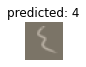

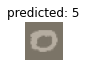

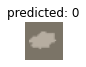

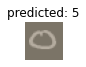

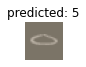

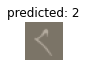

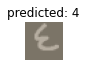

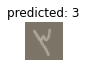

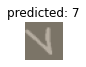

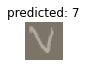

In [53]:
visualize_model(model)

# From pytorch to ONNX

In [ ]:
! pip install numpy protobuf==3.16.0
! pip install onnx
! pip install onnxruntime

In [64]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [69]:
num_layers = len(list(model.parameters())) #64

In [70]:
num_layers

62

In [ ]:
dummy_input = torch.rand(1, 1, 28, 28).to(device)
model = model.to(device)
input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(num_layers) ]
output_names = [ "output1" ]
torch.onnx.export(model, dummy_input, "resnet.onnx", verbose=True, input_names=input_names, output_names=output_names)

In [ ]:
import onnx

onnx_model = onnx.load("resnet.onnx")

onnx.checker.check_model(onnx_model)

print(onnx.helper.printable_graph(onnx_model.graph))

In [58]:
import onnxruntime as ort

In [ ]:
ort_session = ort.InferenceSession("resnet.onnx")

outputs = ort_session.run(
    None,
    {"actual_input_1": np.random.randn(1, 1, 28, 28).astype(np.float32)},
)
print(outputs[0])

In [61]:
outputs[0].shape

(1, 1000)